# Minimal action path for the Maier-Stein model.
```
Notebook reproducing minimal action path for the Maier-Stein model.
Author: Orjan Ameye (orjan.ameye@hotmail.com)
Date: 13 Feb 2024
```

In [4]:
using CriticalTransitions, StaticArrays, LinearAlgebra

using CairoMakie
using MathTeXEngine: get_font
font = (;
    regular = get_font(:regular), bold = get_font(:bold),
    italic = get_font(:italic), bold_italic = get_font(:bolditalic)
)
using Colors, ColorSchemes

Let us explore the features of [CriticalTransitions.jl](https://github.com/JuliaDynamics/CriticalTransitions.jl) with Maier-Stein model.

## Maier-stein model

The [Maier-Stein model](https://link.springer.com/article/10.1007/BF02183736) (J. Stat. Phys 83, 3–4 (1996)) is commonly used in the field of nonlinear dynamics for benchmarking Large Deviation Theory (LDT) techniques, e.g., stoachastic transitions between different stable states. It is a simple model that describes the dynamics of a system with two degrees of freedom $u$ and $v$, and is given by the following set of ordinary differential equations:
\begin{align}
    \dot{u} &= u-u^3 - \beta*u*v^2\\
    \dot{v} &= -\alpha (1+u^2)*v
\end{align}
The parameter $\alpha>0$ controls the strength of the drift field and $\beta>0$ represents the softening of that drift field.

In [5]:
function meier_stein!(du, u, p, t) # in-place
    x, y = u
    du[1] = x-x^3 -10*x*y^2
    du[2] = -(1+x^2)*y
end
function meier_stein(u, p, t) # out-of-place
    x, y = u
    dx = x-x^3 -10*x*y^2
    dy = -(1+x^2)*y
    SA[dx, dy]
end
σ = 0.25
sys = CoupledSDEs(meier_stein, idfunc, zeros(2), (), σ)

2-dimensional CoupledSDEs
 deterministic: true
 discrete time: false
 in-place:      false
 dynamic rule:  SDEFunction
 parameters:    ()
 time:          0.0
 state:         [0.0, 0.0]


A good reference to read about the large deviations methods is [this](https://homepages.warwick.ac.uk/staff/T.Grafke/simplified-geometric-minimum-action-method-for-the-computation-of-instantons.html) or [this]( https://homepages.warwick.ac.uk/staff/T.Grafke/simplified-geometric-minimum-action-method-for-the-computation-of-instantons.html) blog post by Tobias Grafke.

## Attractors

We start by investigating the deterministic dynamics of the Maier-Stein model.

The function `fixed points` return the attractors, their eigenvalues and stability within the state space volume defined by `bmin` and `bmax`.

In [6]:
using ChaosTools
u_min = -1.1; u_max = 1.1;
v_min = -0.4; v_max = 0.4
bmin = [u_min, v_min]; bmax = [u_max, v_max]
fp, eig, stab = fixedpoints(sys, bmin, bmax)
stable_fp = fp[stab]

2-dimensional StateSpaceSet{Float64} with 2 points
 -1.0   2.33693e-28
  1.0  -6.37082e-28

2-dimensional StateSpaceSet{Float64} with 3 points
  9.15652e-20  -3.56338e-21
 -1.0           2.33693e-28
  1.0          -6.37082e-28

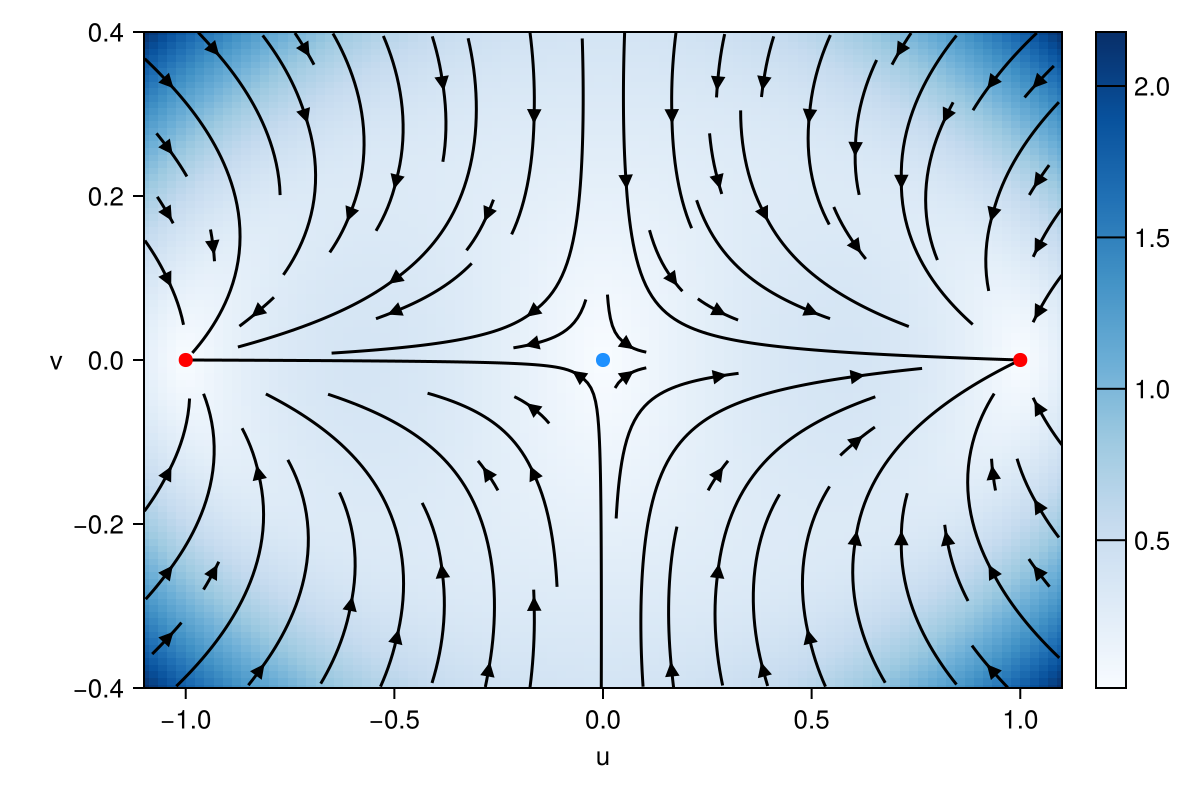

In [7]:
res = 100
u_range = range(u_min, u_max, length = res)
v_range = range(v_min, v_max, length = res)

du(u, v) =   u-u^3 -10*u*v^2
dv(u, v) = -(1+u^2)*v
odeSol(u, v) = Point2f(du(u, v), dv(u, v))

z = [norm([du(x, y), dv(x, y)]) for x in u_range, y in v_range]
zmin, zmax = minimum(z), maximum(z)

fig = Figure(size = (600, 400), fontsize =13)
ax = Axis(fig[1, 1], xlabel = "u", ylabel = "v", aspect=1.4,
    xgridcolor = :transparent, ygridcolor = :transparent,
    ylabelrotation = 0)

hm = heatmap!(ax, u_range, v_range, z, colormap = :Blues, colorrange = (zmin, zmax))
Colorbar(fig[1, 2], hm; label = "", width = 15, ticksize = 15, tickalign = 1)
streamplot!(ax, odeSol, (u_min, u_max), (v_min, v_max);
    gridsize = (20, 20), arrow_size = 10, stepsize = 0.01,
    colormap = [:black, :black]
    )
colgap!(fig.layout, 7)
limits!(u_min,u_max,v_min,v_max)
fig

[scatter!(ax, Point(fp[i]), color = stab[i] > 0 ? :red : :dodgerblue,
    markersize = 10) for i in eachindex(fp)]
fig

## Transitions

We can quickly find a path which computes a transition from one attractor to another using the function `transition.

In [8]:
path, time, succes = transition(sys, fp[stab][1], fp[stab][2])

MethodError: MethodError: RecursiveArrayTools.DiffEqArray(::Vector{SVector{2, Float64}}, ::Vector{Float64}, ::Tuple{}, ::SDEFunction{false, SciMLBase.FullSpecialize, SDEFunction{false, SciMLBase.FullSpecialize, typeof(meier_stein), typeof(idfunc), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, CriticalTransitions.var"#1#2"{Float64, typeof(idfunc)}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}) is ambiguous.

Candidates:
  RecursiveArrayTools.DiffEqArray(vec::AbstractVector{T}, ts::AbstractVector, ::NTuple{N, Int64}, p; ...) where {T, N}
    @ RecursiveArrayTools C:\Users\orjan\.julia\packages\RecursiveArrayTools\K1bCr\src\vector_of_array.jl:175
  RecursiveArrayTools.DiffEqArray(vec::AbstractVector{VT}, ts::AbstractVector, p, sys; variables, parameters, independent_variables, discretes) where {T, N, VT<:AbstractArray{T, N}}
    @ RecursiveArrayTools C:\Users\orjan\.julia\packages\RecursiveArrayTools\K1bCr\src\vector_of_array.jl:237

Possible fix, define
  RecursiveArrayTools.DiffEqArray(::AbstractVector{VT}, ::AbstractVector, ::NTuple{N, Int64}, ::Any) where {T, N, VT<:AbstractArray{T, N}, N}


## Large deviation theory

In the context of nonlinear dynamics, Large Deviation Theory provides tools to quantify the probability of rare events that deviate significantly from the system's typical behavior. These rare events might be extreme values of a system's output, sudden transitions between different states, or other phenomena that occur with very low probability but can have significant implications for the system's overall behavior.

Large deviation theory applies principles from probability theory and statistical mechanics to develop a rigorous mathematical description of these rare events. It uses the concept of a rate function, which measures the exponential decay rate of the probability of large deviations from the mean or typical behavior. This rate function plays a crucial role in quantifying the likelihood of rare events and understanding their impact on the system.

For example, in a system exhibiting chaotic behavior, LDT can help quantify the probability of sudden large shifts in the system's trajectory. Similarly, in a system with multiple stable states, it can provide insight into the likelihood and pathways of transitions between these states under fluctuations. In the context of the Minimum Action Method (MAM) and the Geometric Minimum Action Method (gMAM), Large Deviation Theory is used to handle the large deviations action functional on the space of curves. This is a key part of how these methods analyze dynamical systems.

The Maier-Stein model is a typical benchmark to test such LDT techniques. Let us try to reproduce the following figure from [Tobias Grafke's blog post](https://homepages.warwick.ac.uk/staff/T.Grafke/rogue-waves-and-large-deviations.html):

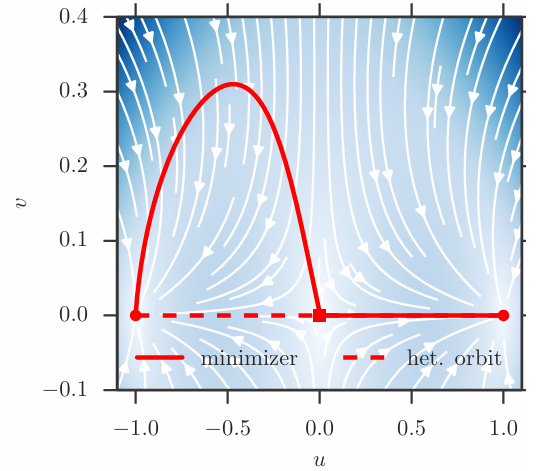

Let us first make an initial path:

In [9]:
xx = range(-1.0,1.0, length=100)
yy = 0.3 .* (- xx .^ 2 .+ 1)
init = Matrix([xx yy]')

2×100 Matrix{Float64}:
 -1.0  -0.979798   -0.959596   -0.939394   …  0.959596   0.979798   1.0
  0.0   0.0119988   0.0237527   0.0352617     0.0237527  0.0119988  0.0

`min_action_method` runs the Minimum Action Method (MAM) to find the minimum action path (instanton) between an initial state x_i and final state x_f. This algorithm uses the minimizers of the [Optim.jl](https://julianlsolvers.github.io/Optim.jl/stable/#) package to minimize the [Freidlin-Wentzell action functional](https://en.wikipedia.org/wiki/Freidlin%E2%80%93Wentzell_theorem) (see `fw_action`) or [Onsager-Machlup action functional](https://en.wikipedia.org/wiki/Onsager%E2%80%93Machlup_function) (see `om_action`) for the given StochSystem `sys`.

In [ ]:
mm = min_action_method(sys, init, 1, maxiter=200, verbose=true)

=== Initializing MAM action minimizer ===
 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     2.036502e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 2.46e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.46e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.02e-08 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.47e-08 ≰ 0.0e+00
    |g(x)|                 = 4.58e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    200
    f(x) calls:    600
    ∇f(x) calls:   600



2×100 Matrix{Float64}:
 -1.0  -0.980207    -0.953454     …  0.95468     0.979916    1.0
  0.0   8.91541e-5   0.000190693     6.61976e-5  1.95431e-5  0.0

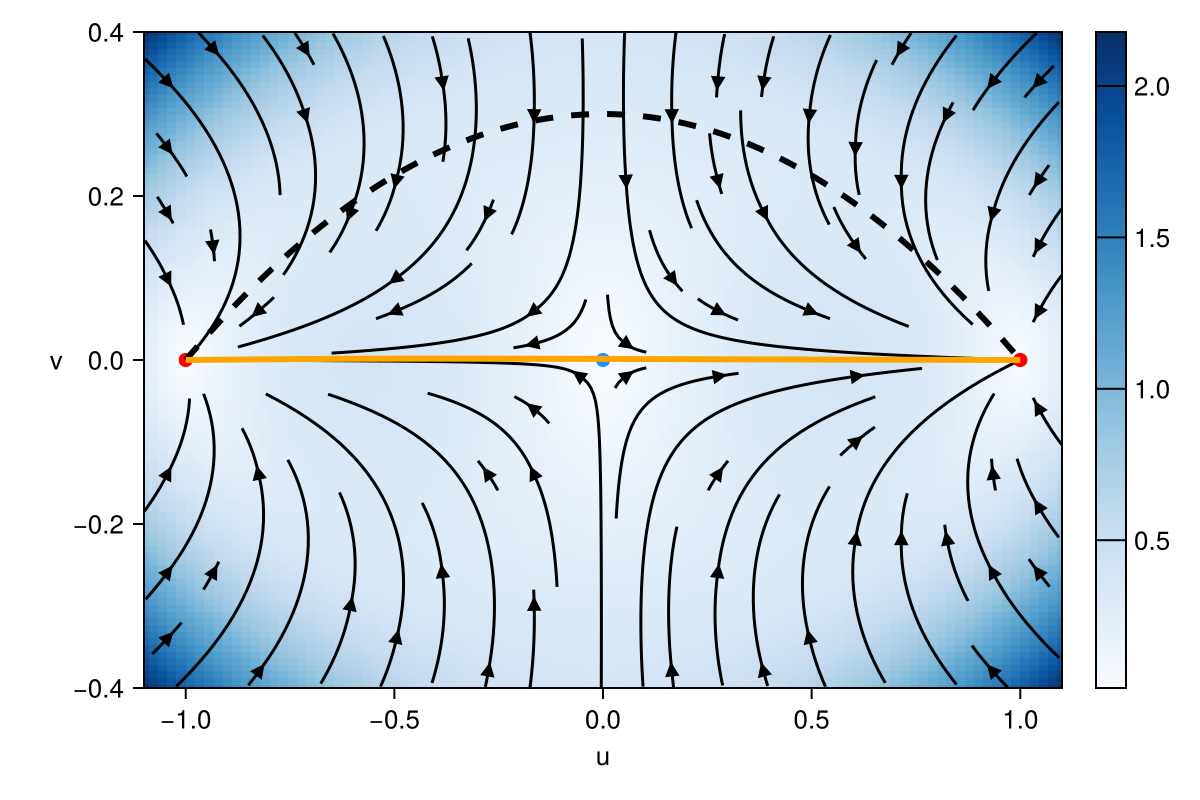

In [13]:
fig = Figure(size = (600, 400), fontsize =13)
ax = Axis(fig[1, 1], xlabel = "u", ylabel = "v", aspect=1.4,
    xgridcolor = :transparent, ygridcolor = :transparent,
    ylabelrotation = 0)

hm = heatmap!(ax, u_range, v_range, z, colormap = :Blues, colorrange = (zmin, zmax))
Colorbar(fig[1, 2], hm; label = "", width = 15, ticksize = 15, tickalign = 1)
streamplot!(ax, odeSol, (u_min, u_max), (v_min, v_max);
    gridsize = (20, 20), arrow_size = 10, stepsize = 0.01,
    colormap = [:black, :black]
    )
colgap!(fig.layout, 7)
limits!(u_min,u_max,v_min,v_max)
fig

[scatter!(ax, Point(fp[i]), color = stab[i] > 0 ? :red : :dodgerblue,
    markersize = 10) for i in eachindex(fp)]

lines!(ax, init, linewidth = 3, color = :black, linestyle = :dash)
lines!(ax, mm, linewidth = 3, color = :orange)
fig

TODO: Why does MAM get the wrong results?

`geometric_min_action_method` computes the minimizer of the Freidlin-Wentzell action using the geometric minimum action method (gMAM). The Minimum Action Method (MAM) is a more traditional approach, while the Geometric Minimum Action Method (gMAM) is a blend of the original MAM and the [string method](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.66.052301).

In [14]:
gm = geometric_min_action_method(sys, init, converge=1e-7, maxiter=1000)

=== Initializing gMAM action minimizer ===
Converged after 440 iterations.


([[-1.0 -0.9797979797979798 … 0.9797979797979798 1.0; 0.0 0.01199877563513928 … 0.01199877563513928 0.0], [-1.0 -0.9987120002958464 … 0.9769419186184787 1.0; 0.0 0.010639363142842986 … 0.0023186530198424328 0.0], [-1.0 -0.9863185974079768 … 0.9762836193843625 1.0; 0.0 0.018030683743767584 … 0.0020572827269200148 0.0], [-1.0 -0.9873277981788814 … 0.9762906855216735 1.0; 0.0 0.019776349490637765 … 0.002190524726134236 0.0], [-1.0 -0.9931629073820851 … 0.9773386779240483 1.0; 0.0 0.02014623638458417 … 0.0020844129016728222 0.0], [-1.0 -0.9913879142419587 … 0.9778149946564213 1.0; 0.0 0.02072987024713815 … 0.0020392174859254954 0.0], [-1.0 -0.9915139763958523 … 0.9779304077037321 1.0; 0.0 0.02048000508743282 … 0.002025490732006632 0.0], [-1.0 -0.9915211237007958 … 0.9779378070473124 1.0; 0.0 0.020470343447128832 … 0.0020216019209689526 0.0], [-1.0 -0.9915637924245178 … 0.9779458201455477 1.0; 0.0 0.020477933990932 … 0.002019142935915394 0.0], [-1.0 -0.991636290802985 … 0.9779501078495635 1

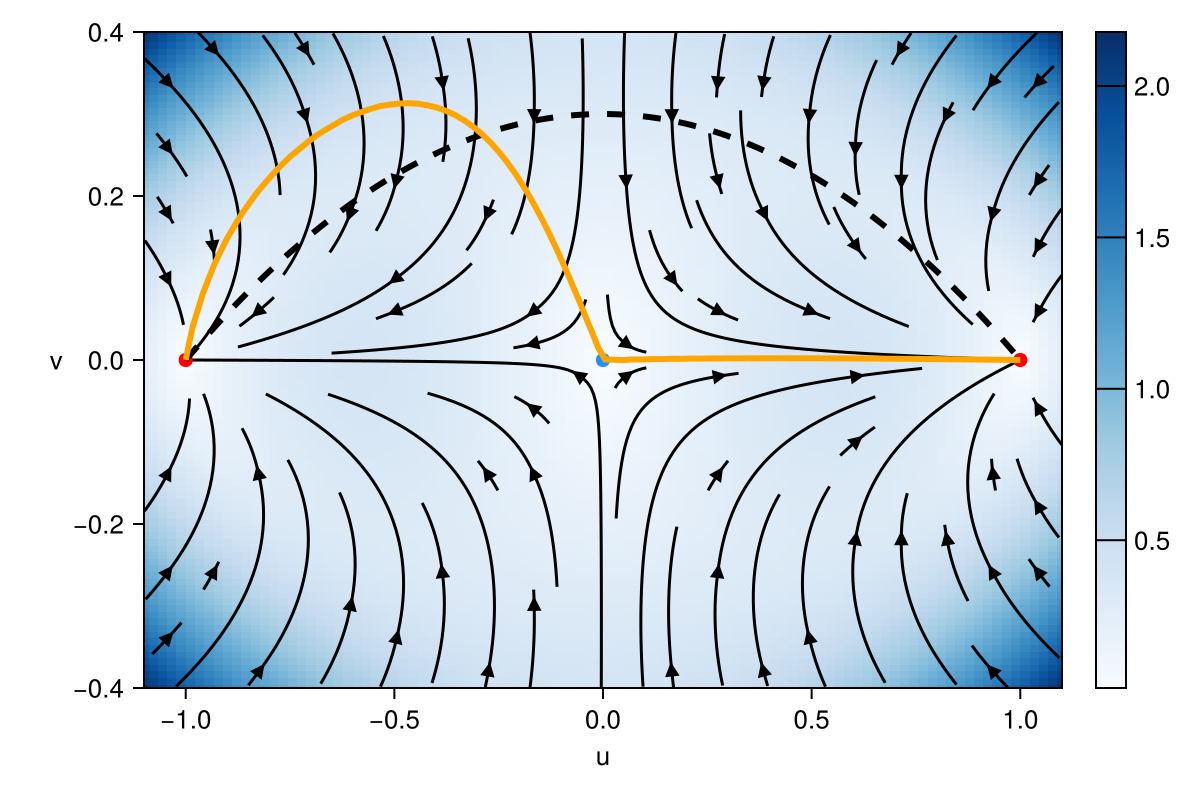

In [15]:
fig = Figure(size = (600, 400), fontsize =13)
ax = Axis(fig[1, 1], xlabel = "u", ylabel = "v", aspect=1.4,
    xgridcolor = :transparent, ygridcolor = :transparent,
    ylabelrotation = 0)

hm = heatmap!(ax, u_range, v_range, z, colormap = :Blues, colorrange = (zmin, zmax))
Colorbar(fig[1, 2], hm; label = "", width = 15, ticksize = 15, tickalign = 1)
streamplot!(ax, odeSol, (u_min, u_max), (v_min, v_max);
    gridsize = (20, 20), arrow_size = 10, stepsize = 0.01,
    colormap = [:black, :black]
    )
colgap!(fig.layout, 7)
limits!(u_min,u_max,v_min,v_max)
fig

[scatter!(ax, Point(fp[i]), color = stab[i] > 0 ? :red : :dodgerblue,
    markersize = 10) for i in eachindex(fp)]

# len = length(gm[1])
# for i in 2:(len-20)
#     i & 10 == 0 && lines!(ax, gm[1][i], linewidth = 3, color = (:black, i/(3*len)))
# end
lines!(ax, gm[1][1], linewidth = 3, color = :black, linestyle = :dash)
lines!(ax, gm[1][end], linewidth = 3, color = :orange)
# lines!(ax, mm, linewidth = 3, color = :orange)
fig